# Final Project Analysis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import dateutil.parser
import os
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## Data Preprocessing

In [52]:
file_path = os.path.join('..', 'data', 'QueryResults.csv')
_df = pd.read_csv(file_path)

In [53]:

_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  50000 non-null  int64 
 1   reputation          50000 non-null  int64 
 2   creationDate        50000 non-null  object
 3   lastAccessDate      50000 non-null  object
 4   views               50000 non-null  int64 
 5   upVotes             50000 non-null  int64 
 6   downVotes           50000 non-null  int64 
 7   postCount           50000 non-null  int64 
 8   commentCount        50000 non-null  int64 
 9   voteCount           50000 non-null  int64 
 10  editCount           50000 non-null  int64 
 11  suggestedEditCount  50000 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 4.6+ MB


In [54]:
_df['creationDate'] = pd.to_datetime(_df['creationDate'])
_df['lastAccessDate'] = pd.to_datetime(_df['lastAccessDate'])

In [55]:
fixed_date_string = "2024-11-29T18:51:13.002Z" 
fixed_date_object = dateutil.parser.isoparse(fixed_date_string)

df = _df.drop(columns=['id', 'creationDate', 'lastAccessDate', 'upVotes', 'downVotes'])

df['votes'] = _df['upVotes'] + _df['downVotes']
df['activeDays'] = (_df['lastAccessDate'] - _df['creationDate']).dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   reputation          50000 non-null  int64
 1   views               50000 non-null  int64
 2   postCount           50000 non-null  int64
 3   commentCount        50000 non-null  int64
 4   voteCount           50000 non-null  int64
 5   editCount           50000 non-null  int64
 6   suggestedEditCount  50000 non-null  int64
 7   votes               50000 non-null  int64
 8   activeDays          50000 non-null  int64
dtypes: int64(9)
memory usage: 3.4 MB


In [56]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,reputation,views,postCount,commentCount,voteCount,editCount,suggestedEditCount,votes,activeDays
0,0.001874,0.001367,0.001802,0.003481,0.0,0.000934,0.01567,0.001732,0.529738
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.266973
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.013769
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000


## Data Analysis

### KMeans

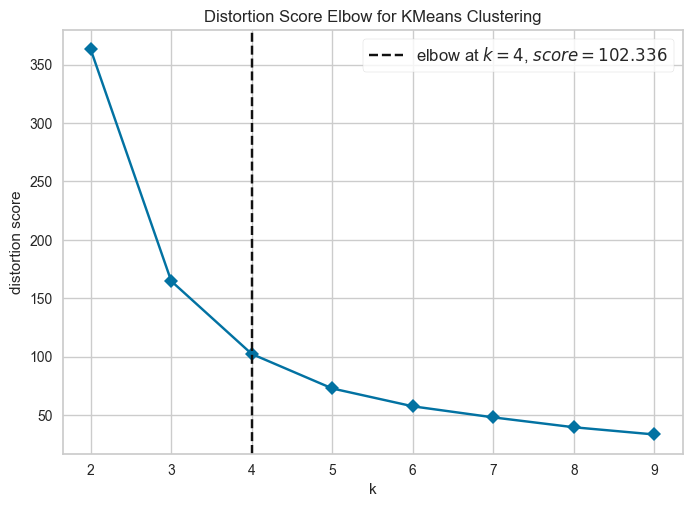

In [57]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False)
visualizer.fit(df_scaled)
visualizer.show()
plt.show()

In [58]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_scaled)
df["cluster"] = kmeans.labels_

### Agglomerative

In [59]:
# find linkage
linkage_method = 'ward'
linkage_path = os.path.join('.', 'cache', f"linkage_{linkage_method}.npy")

if os.path.exists(linkage_path):
  print("Loading linkage matrix from cache")
  linkage_matrix = np.load(linkage_path, allow_pickle=True)
else:
  print("Calculating linkage matrix from cache")
  linkage_matrix = linkage(df_scaled, linkage_method)
  np.save(linkage_path, linkage_matrix)

Loading linkage matrix from cache


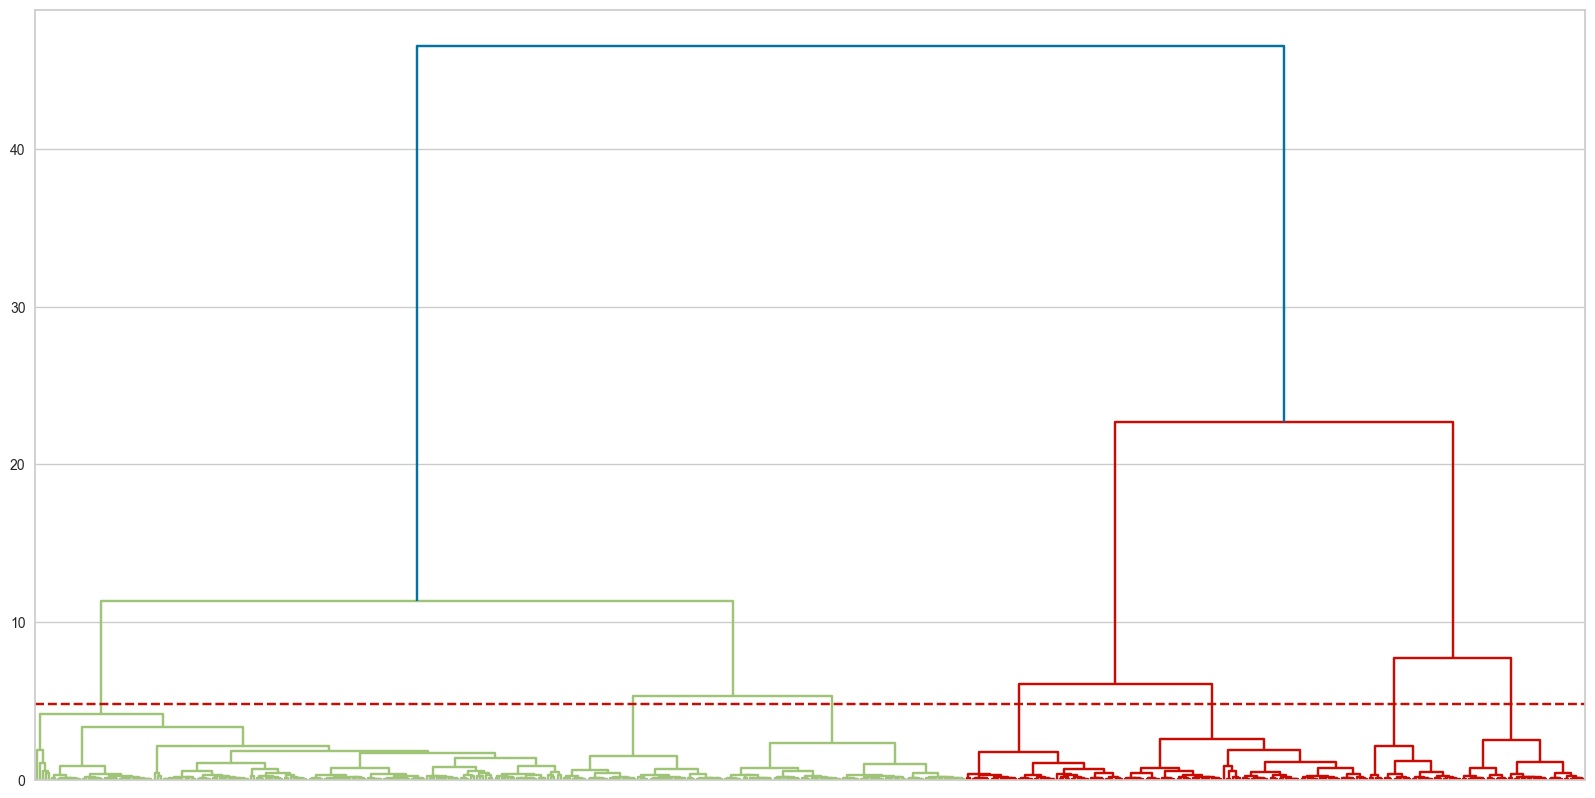

In [60]:
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix, truncate_mode='lastp', p=500)
plt.gca().get_xaxis().set_visible(False)
plt.axhline(y=4.8, color='r', linestyle='--')
plt.show()

In [65]:
# train with optimal number of clusters
path = os.path.join('.', 'cache', 'models', 'agglomerative')
agglomerative = AgglomerativeClustering(n_clusters=7, linkage=linkage_method, memory=path)
agglomerative.fit(df_scaled)
df['cluster'] = agglomerative.labels_